# XFactors

### Import

In [5]:
%load_ext autoreload
%autoreload 2

import os
PROJECT_PATH = "/projects/compures/alexandre/disdiff_adapters"
os.chdir(PROJECT_PATH)
print(os.getcwd())

import torch.nn as nn # type: ignore
from torch.utils.data import DataLoader, TensorDataset
import torchvision.utils as vutils

from PIL import Image, ImageDraw, ImageFont
from matplotlib.colors import ListedColormap, BoundaryNorm
from glob import glob

#DataModule
from disdiff_adapters.data_module import *
#Dataset
from disdiff_adapters.dataset import *
#Module
from disdiff_adapters.arch.vae import *
from disdiff_adapters.arch.multi_distillme import *
from disdiff_adapters.arch.classifier import *
#utils
from disdiff_adapters.utils import *
#loss   
from disdiff_adapters.loss import *
#metric
from disdiff_adapters.metric import *

from lightning.pytorch.callbacks import LearningRateMonitor, ModelCheckpoint
from lightning.pytorch.loggers import TensorBoardLogger
from lightning import Trainer
from lightning.pytorch.strategies import DDPStrategy

from disdiff_adapters.arch.multi_distillme import Xfactors
BATCH_SIZE = 32
LATENT_DIM = 2

torch.set_float32_matmul_precision('medium')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/import/pr_compures/alexandre/disdiff_adapters


## Load data 

**Choose the appropriate set :**

### 3DShapes

In [2]:
#6mn30 from ens cluster
shapes = Shapes3DDataModule(batch_size=32)
shapes.prepare_data()
shapes.setup(stage='fit')
shapes_loader = shapes.train_dataloader()

load dataset - train
load dataset val
tensors loaded.


In [3]:
print(len(shapes.train_dataset))

307200


In [4]:
for batch in shapes_loader :
    images, labels = batch
    print(labels.shape)
    break

torch.Size([32, 6])


### CelebA

In [ ]:
celeba = CelebADataModule(batch_size=BATCH_SIZE)
celeba.prepare_data()
celeba.setup("test")
celeba_loader = celeba.train_dataloader()
celeba_val_loader = celeba.val_dataloader()

In [3]:
len(celeba.train_dataset)

162770

### MNIST

In [ ]:
mnist = MNISTDataModule(batch_size=BATCH_SIZE)
mnist.prepare_data()
mnist.setup("fit")
mnist_loader = mnist.train_dataloader()

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.58MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 383kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.07MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 2.40MB/s]


### DSprites

In [ ]:
dsprites = DSpritesDataModule(batch_size=BATCH_SIZE)
dsprites.prepare_data()
dsprites.setup(stage='fit')
dsprites_loader = dsprites.train_dataloader()

load dataset - train
load dataset val
tensors loaded.


### Cars3D

In [6]:
cars3d = Cars3DDataModule(batch_size=BATCH_SIZE)
cars3d.prepare_data()
cars3d.setup(stage='fit')
cars3d_loader = cars3d.train_dataloader()
cars3d_val_loader = cars3d.val_dataloader()

tensors loaded.


### Choose the correct loader

In [7]:
loader = cars3d_loader
val_loader = cars3d_val_loader
stop_at = 0

for i,batch in enumerate(loader) :
    images, labels = batch
    in_channels = images.shape[1]
    img_size = images.shape[2]
    if i == stop_at : break
print(f"Data selected with in_channels={in_channels} and img_size={img_size}")
toy_loader = DataLoader(TensorDataset(images, labels), batch_size=BATCH_SIZE)

Data selected with in_channels=3 and img_size=64


## Xfactors

In [10]:
select_factors=[1,2]
w=len(select_factors)
xfactor = Xfactors(in_channels=3, 
                    img_size=64, 
                    latent_dim_s=126, 
                    select_factors=select_factors, 
                    dims_by_factors=len(select_factors)*[2], 
                    l_nce_by_factors=len(select_factors)*[w*1e-1],
                    beta_s=100.0,
                    map_idx_labels=Cars3D.Params.FACTORS_IN_ORDER,)
trainer = Trainer(gradient_clip_val= 3.0,
                    max_epochs=1,
                    log_every_n_steps=7,)

Trainer will use only 1 of 3 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=3)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]



  | Name         | Type              | Params | Mode 
-----------------------------------------------------------
0 | model        | _MultiDistillMe   | 7.2 M  | train
1 | constrastive | InfoNCESupervised | 0      | train
-----------------------------------------------------------
7.2 M     Trainable params
0         Non-trainable params
7.2 M     Total params
28.866    Total estimated model params size (MB)
87        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/projects/compures/alexandre/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:476: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Epoch 0: 100%|██████████| 469/469 [00:18<00:00, 25.78it/s, v_num=107]      Val loss: 0.42914074659347534
Val loss: 0.44057101011276245
Val loss: 0.3321206271648407
Val loss: 0.5379684567451477
Val loss: 0.43003833293914795
Val loss: 0.3701883554458618
Val loss: 0.4690331518650055
Val loss: 0.3878559470176697
Val loss: 0.4968368709087372
Val loss: 0.4067007005214691
Val loss: 0.5551630854606628
Val loss: 0.5637969970703125
Val loss: 0.43425318598747253
Val loss: 0.4200107157230377
Val loss: 0.49709588289260864
Val loss: 0.3367988169193268
Val loss: 0.45104557275772095
Val loss: 0.34687280654907227
Val loss: 0.4875733554363251
Val loss: 0.44032353162765503
Val loss: 0.45277926325798035
Val loss: 0.5150328278541565
Val loss: 0.35793623328208923
Val loss: 0.5504553318023682
Val loss: 0.5616890788078308
Val loss: 0.4278348386287689
Val loss: 0.3901285231113434
Val loss: 0.45405182242393494
Val loss: 0.4017810523509979
Val loss: 0.38354653120040894
Val loss: 0.5187464356422424
Val loss: 0.39

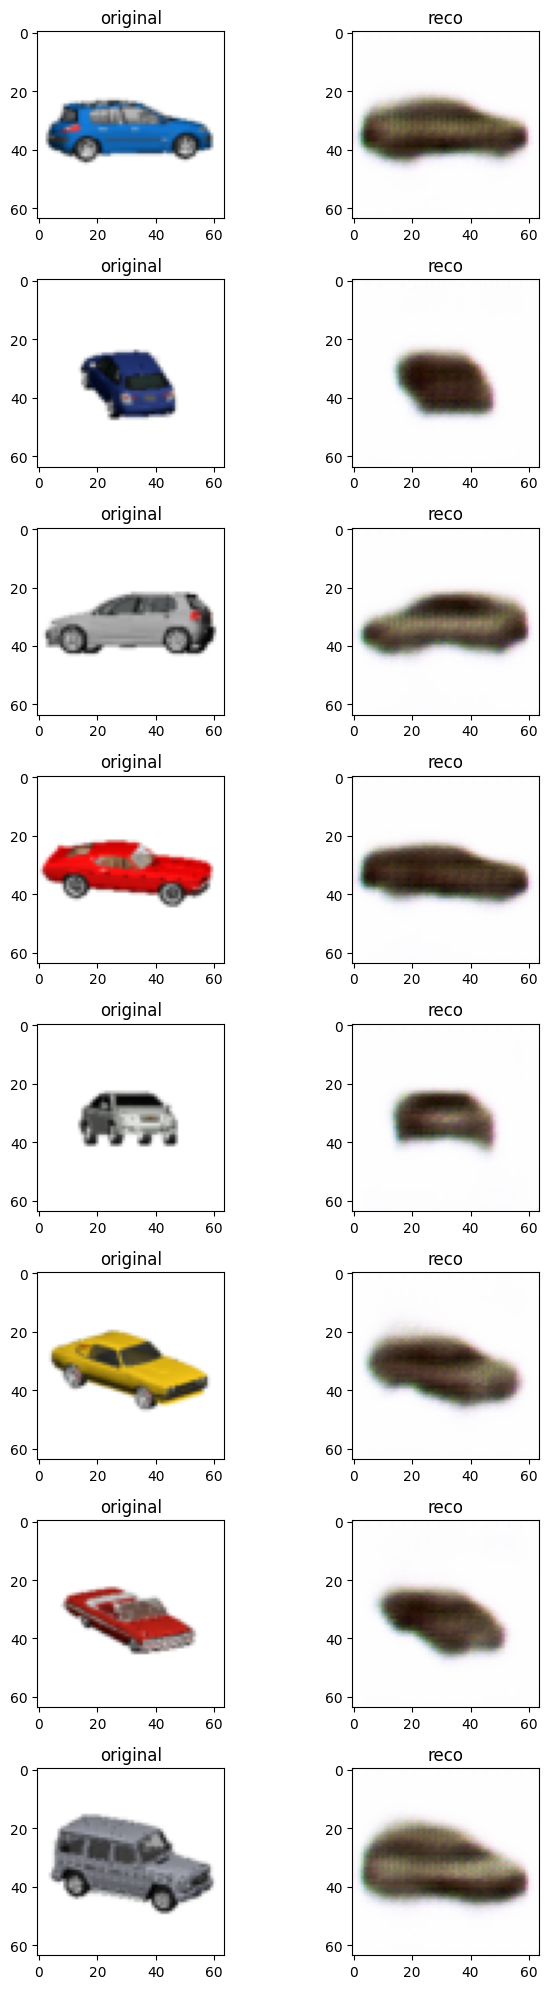

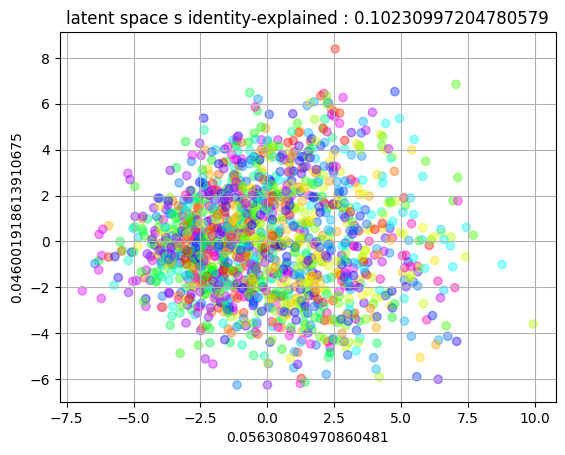

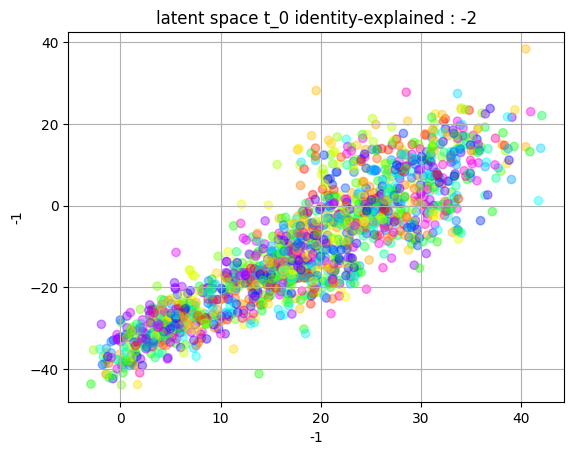

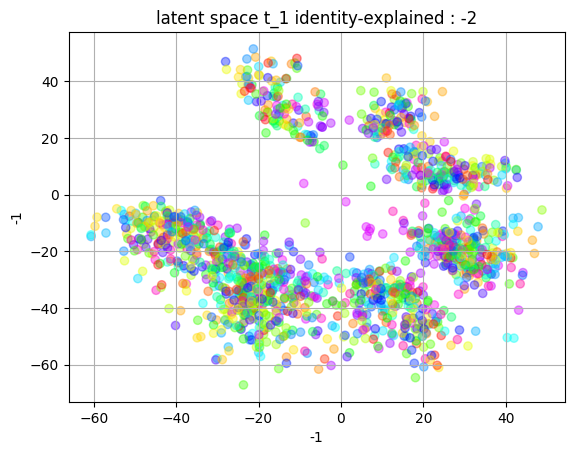

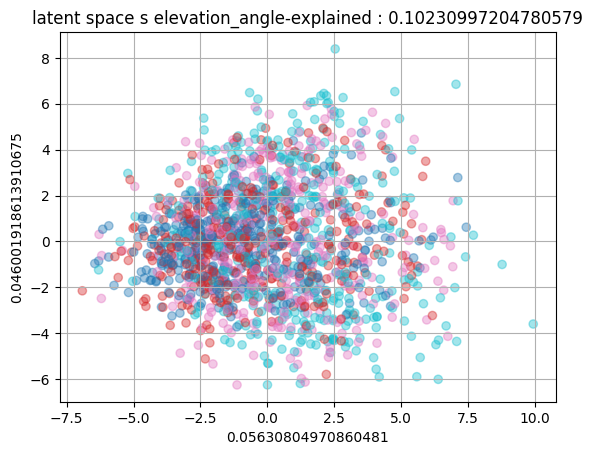

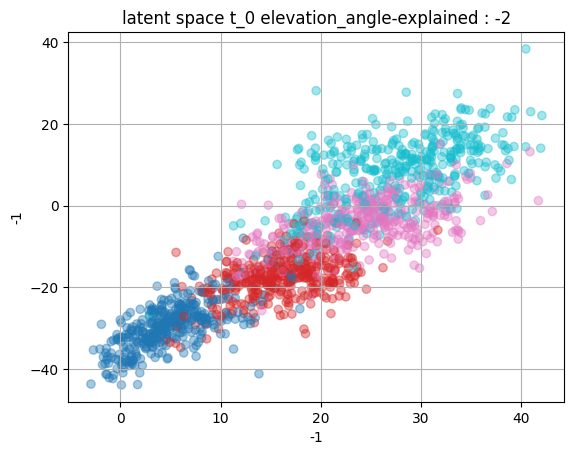

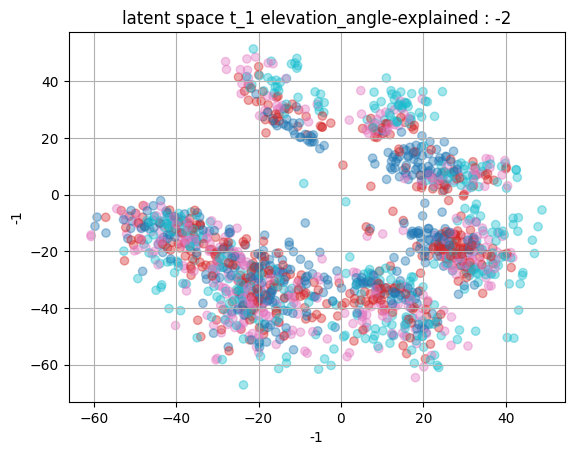

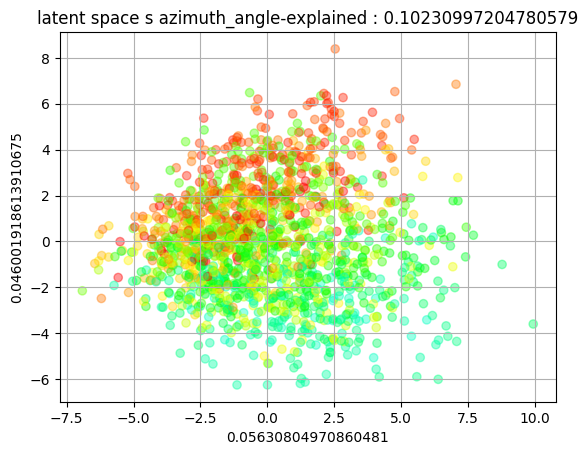

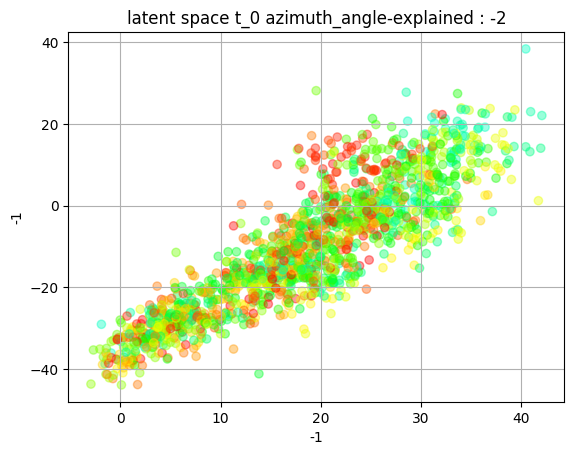

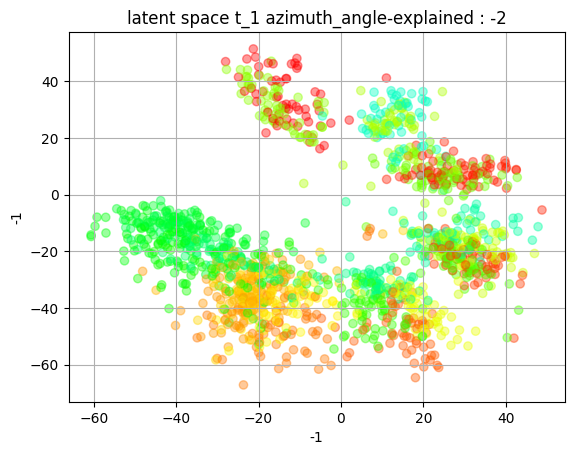

Epoch 0: 100%|██████████| 469/469 [00:27<00:00, 16.90it/s, v_num=107]

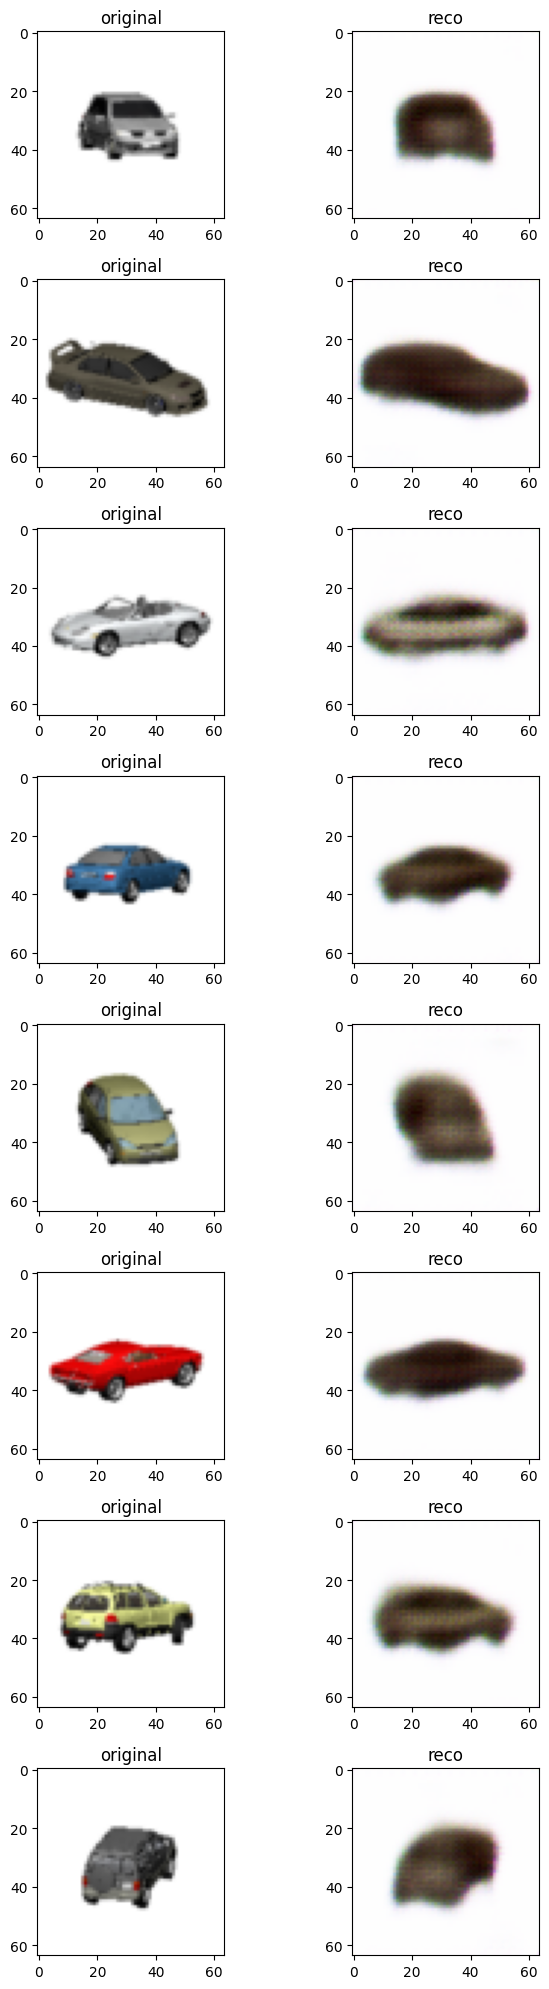

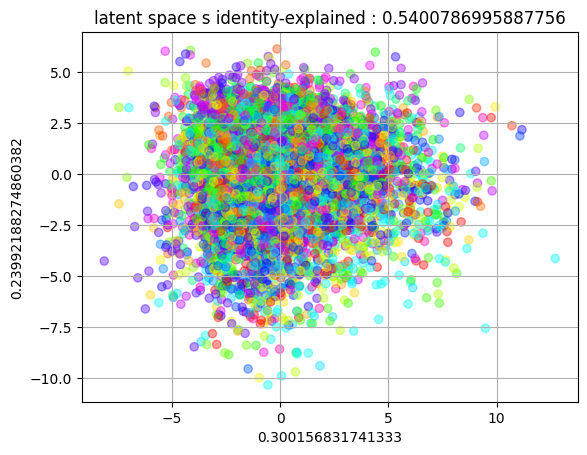

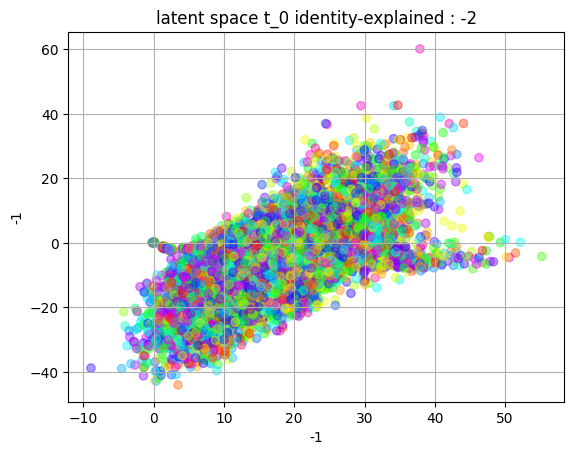

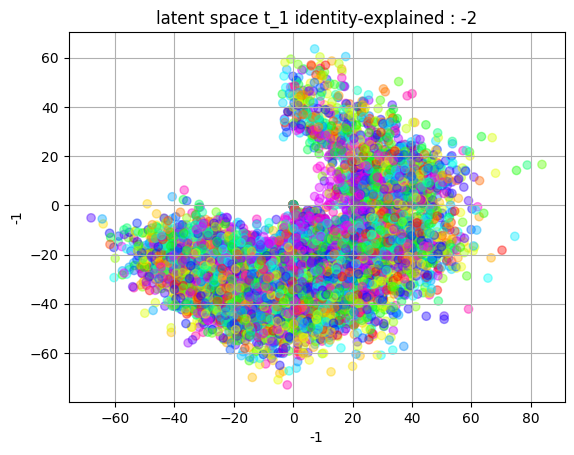

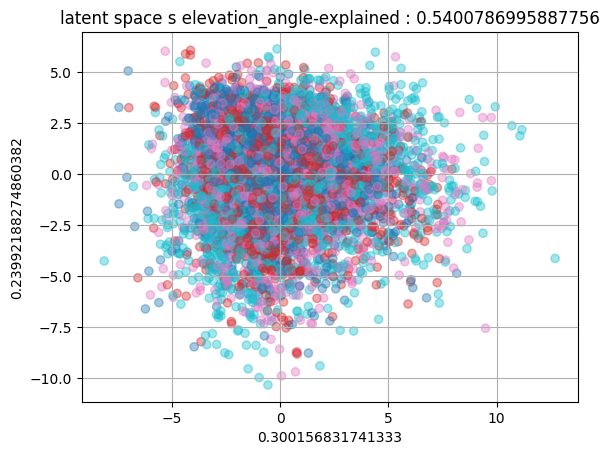

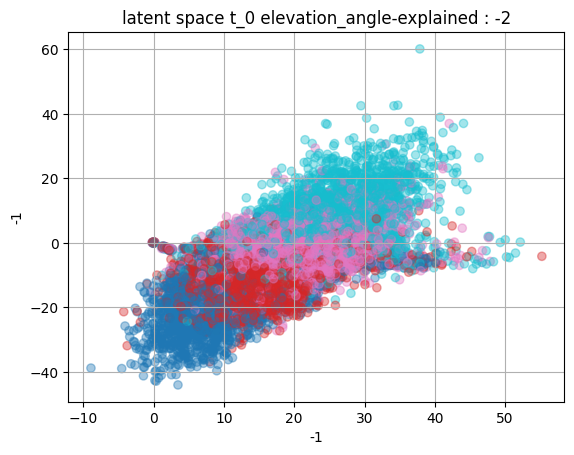

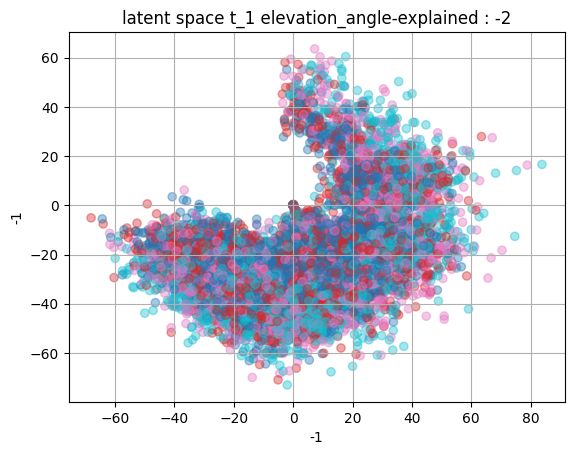

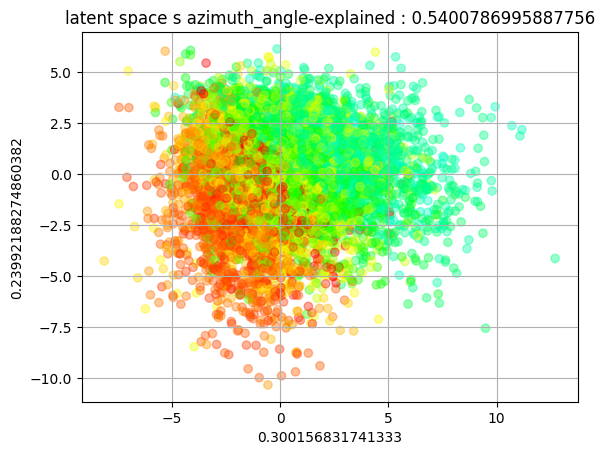

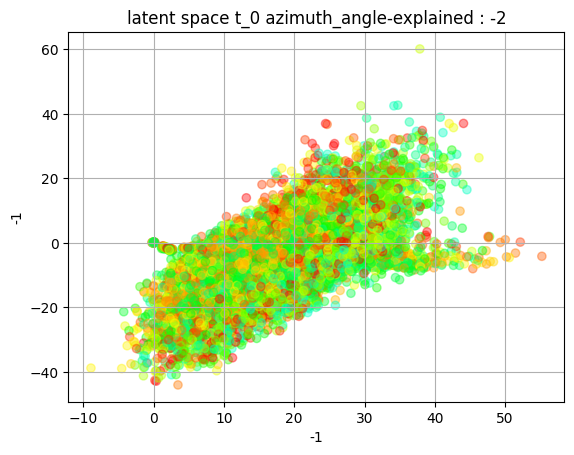

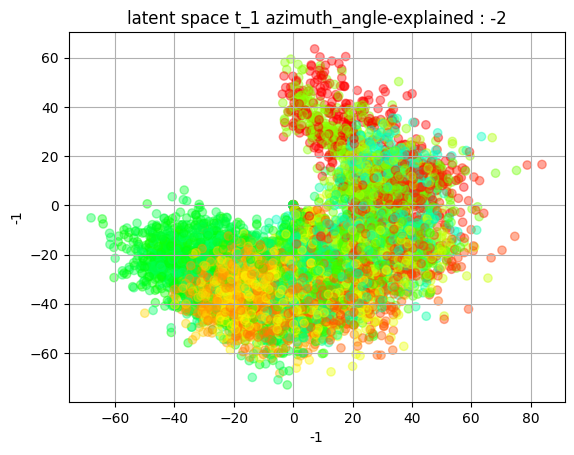

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 469/469 [00:39<00:00, 11.96it/s, v_num=107]


: 

In [ ]:
trainer.fit(xfactor, loader, val_loader)

## Test

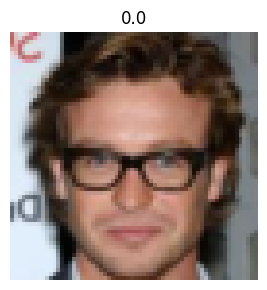

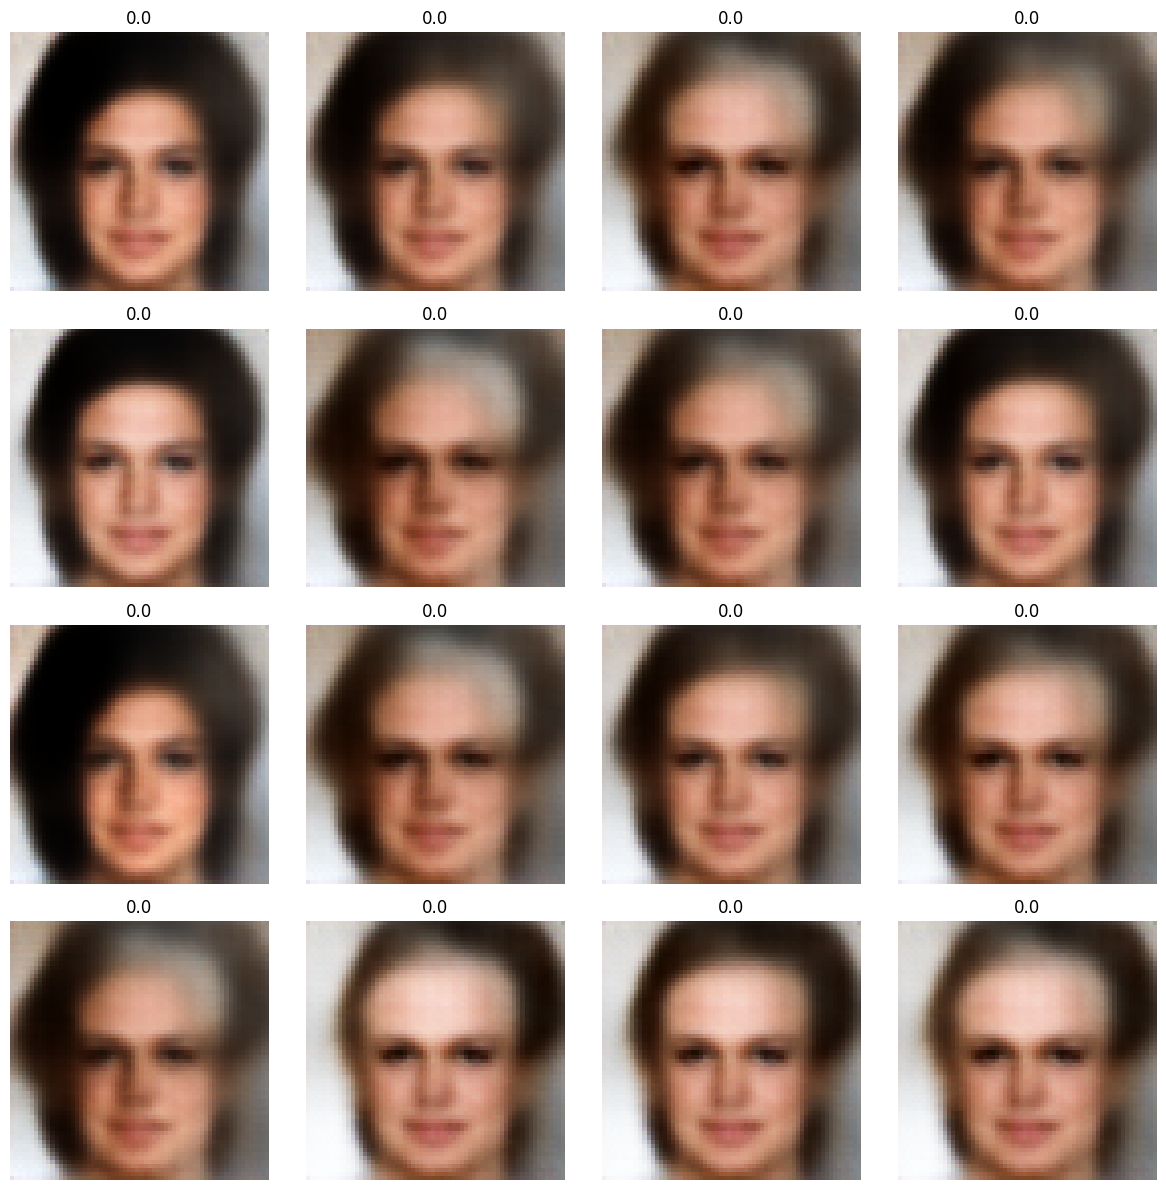

In [37]:
images, ref = xfactor.generate_by_factors(cond=15, img_ref=image.unsqueeze(0))
labels = torch.zeros(images.size(0))
labels_ref = torch.zeros(ref.size(0))
display((ref, labels_ref))
display((images, labels))

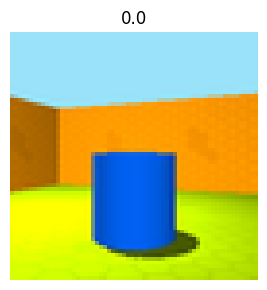

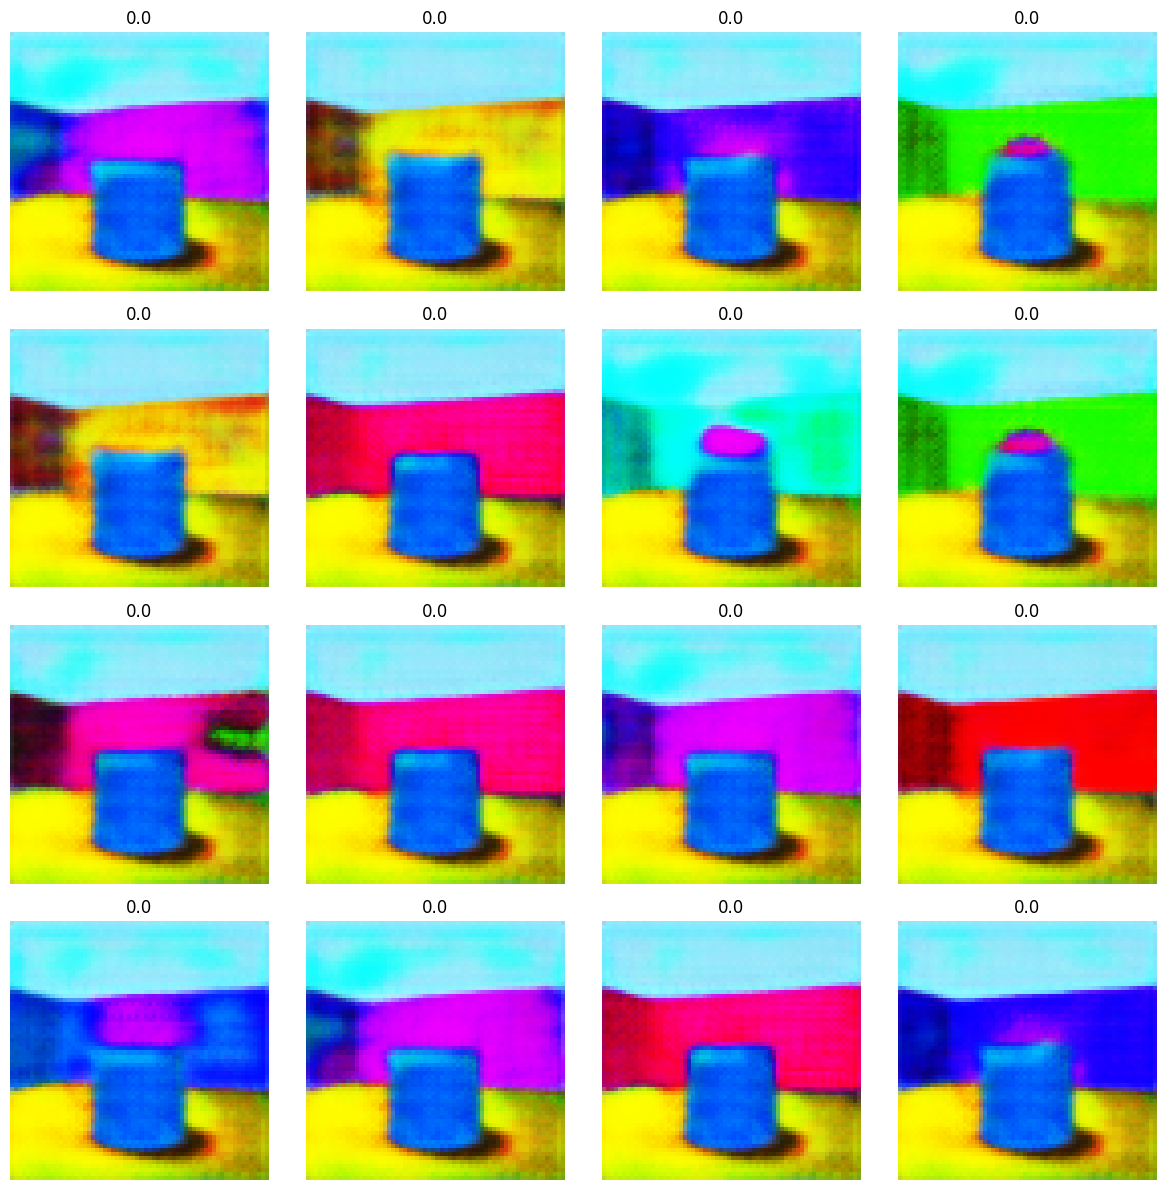

In [18]:
images, ref = xfactor.generate_by_factors(cond=1)
labels = torch.zeros(images.size(0))
labels_ref = torch.zeros(ref.size(0))
display((ref, labels_ref))
display((images, labels))

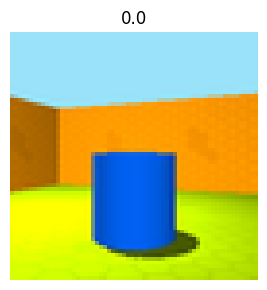

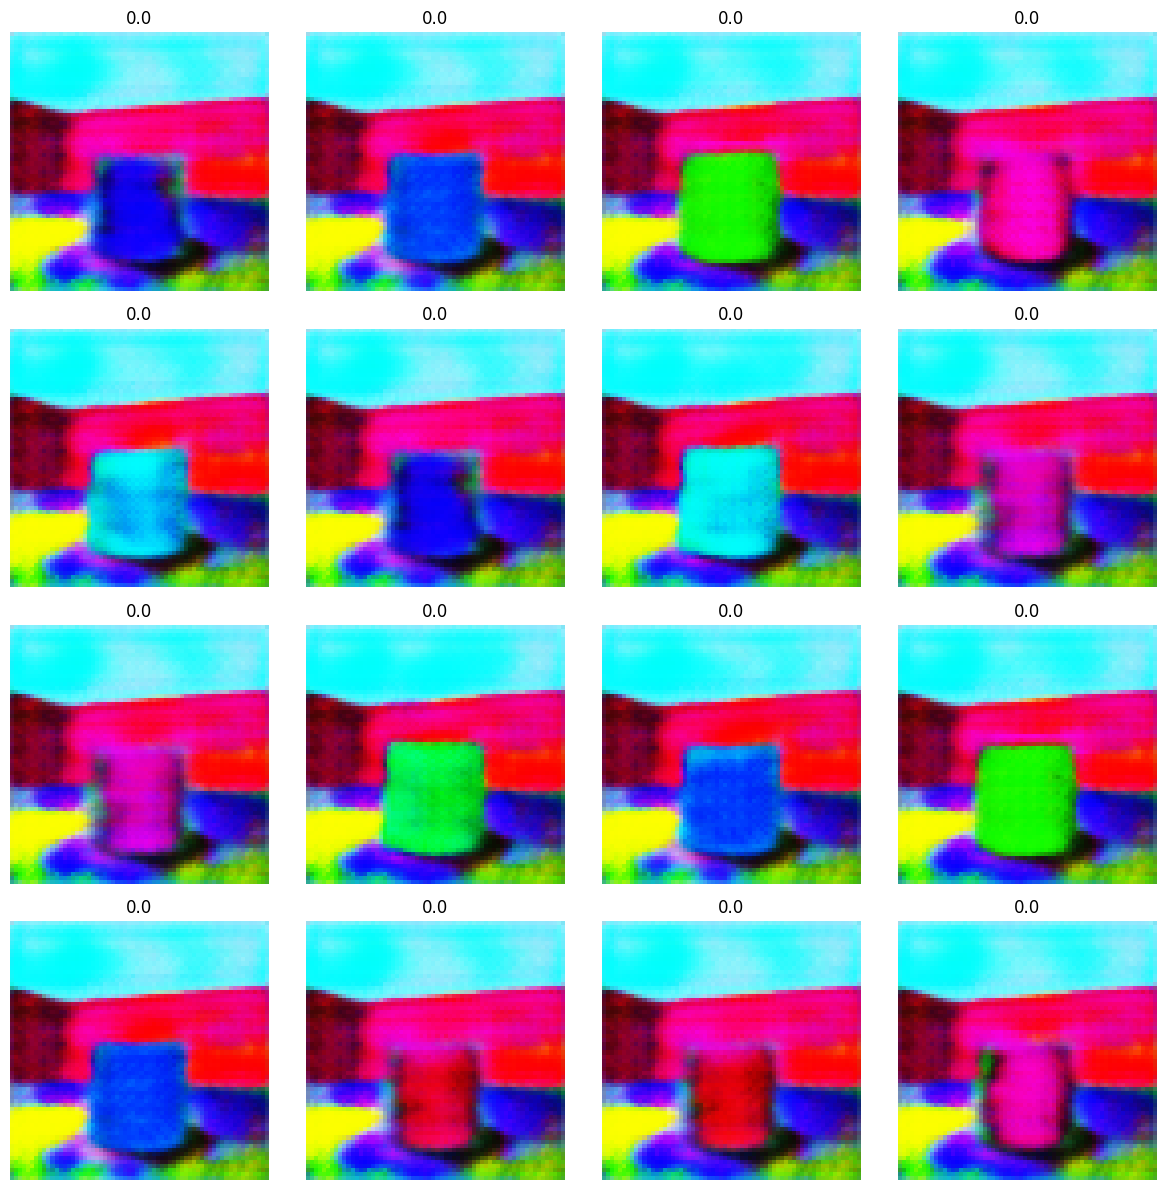

In [20]:
images, ref = xfactor.generate_by_factors(cond=2)
labels = torch.zeros(images.size(0))
labels_ref = torch.zeros(ref.size(0))
display((ref, labels_ref))
display((images, labels))

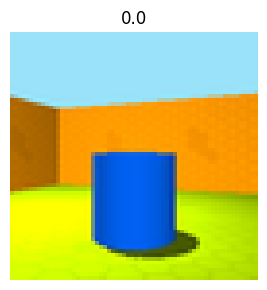

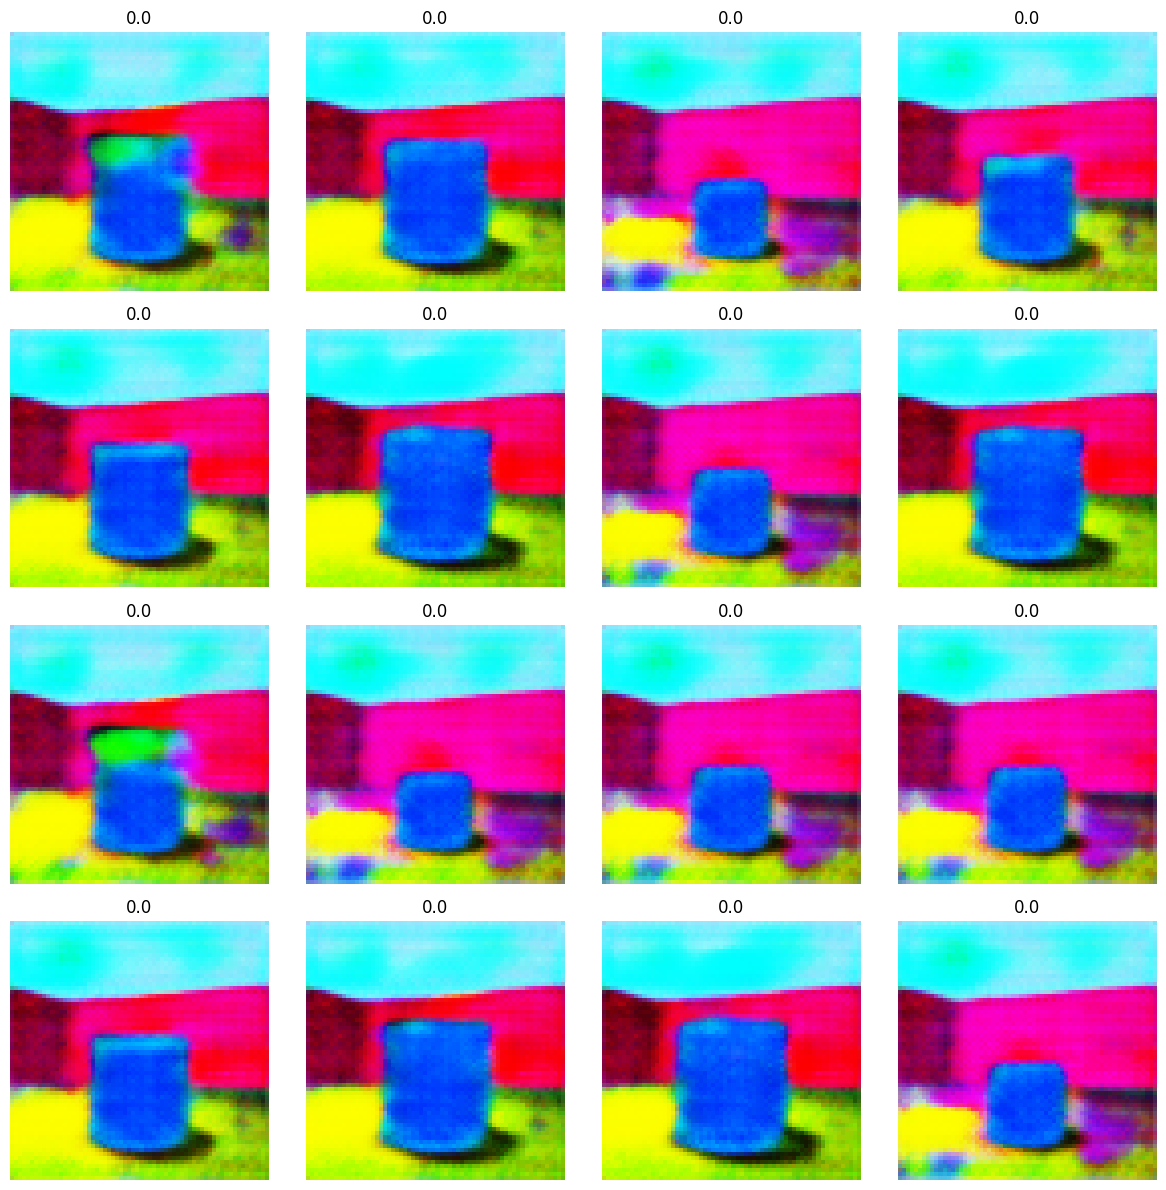

In [21]:
images, ref = xfactor.generate_by_factors(cond=3)
labels = torch.zeros(images.size(0))
labels_ref = torch.zeros(ref.size(0))
display((ref, labels_ref))
display((images, labels))

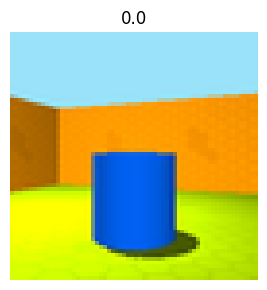

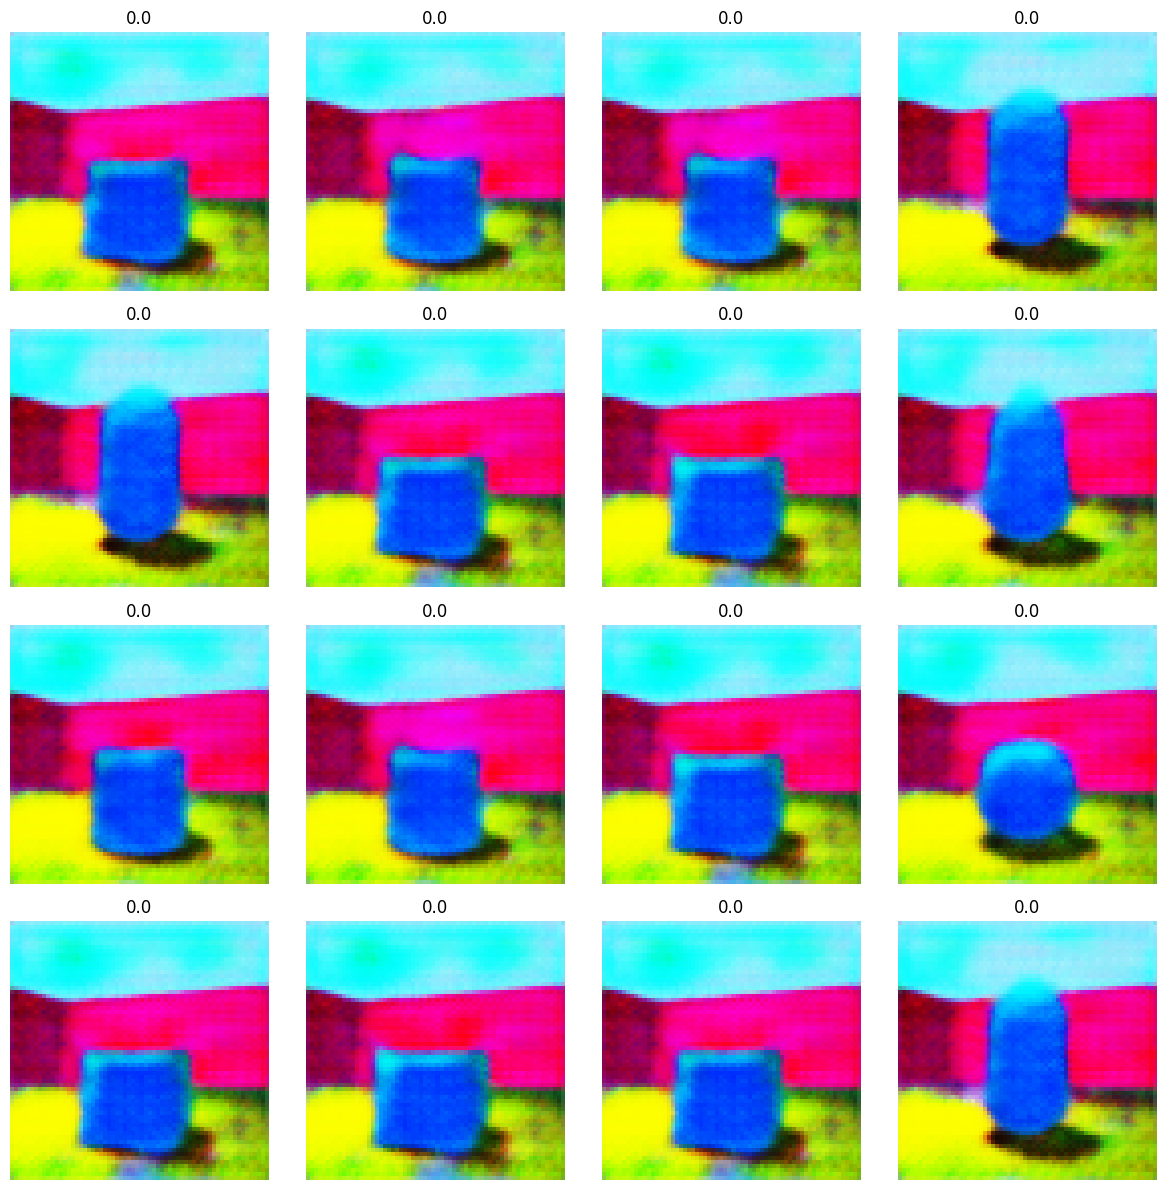

In [22]:
images, ref = xfactor.generate_by_factors(cond=4)
labels = torch.zeros(images.size(0))
labels_ref = torch.zeros(ref.size(0))
display((ref, labels_ref))
display((images, labels))

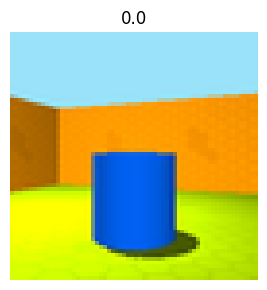

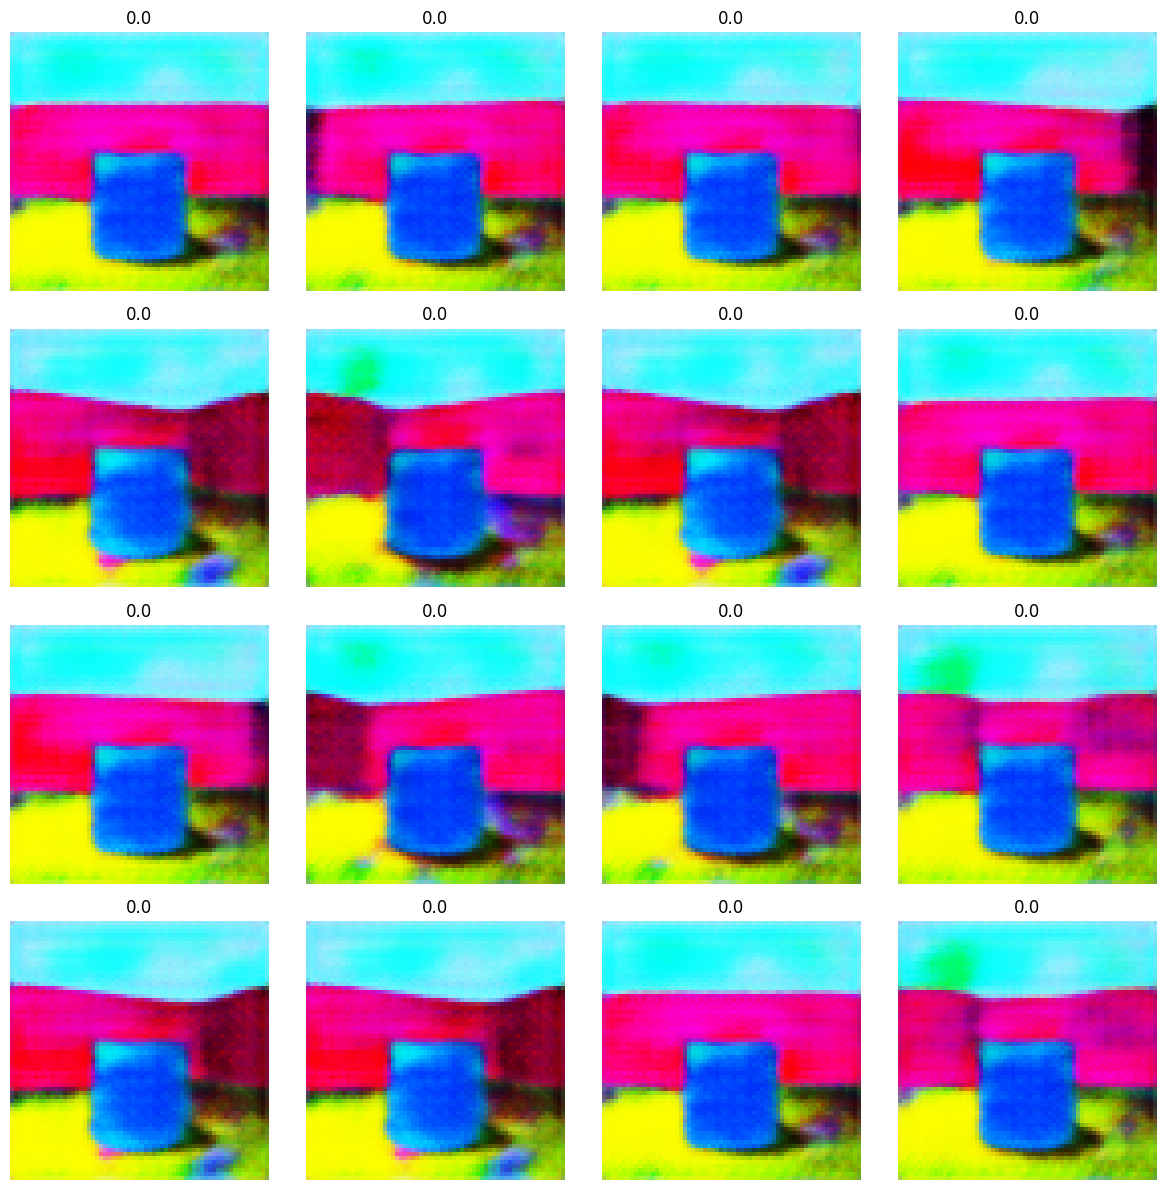

In [23]:
images, ref = xfactor.generate_by_factors(cond=5)
labels = torch.zeros(images.size(0))
labels_ref = torch.zeros(ref.size(0))
display((ref, labels_ref))
display((images, labels))

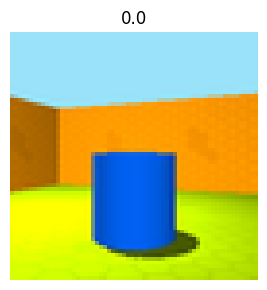

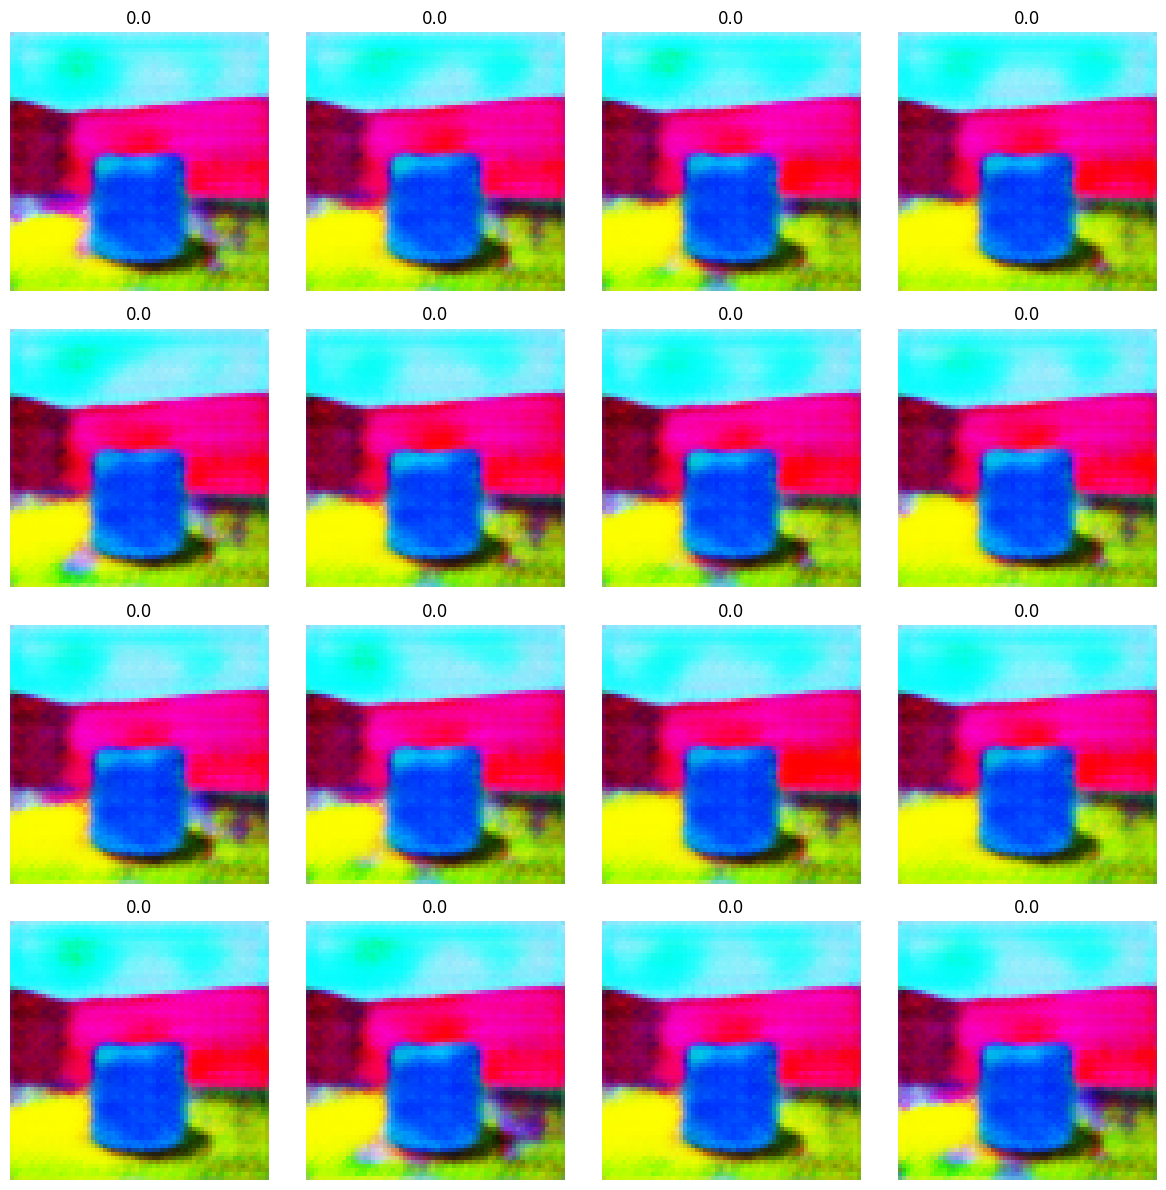

In [24]:
images, ref = xfactor.generate_cond(cond="s")
labels = torch.zeros(images.size(0))
labels_ref = torch.zeros(ref.size(0))
display((ref, labels_ref))
display((images, labels))